# Laboratorio 2: Sistemas de Recomendación

> **Aprendizaje NO Supervisado** - *Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus aplicaciones.* 

> Gonzalo Zigarán

El objetivo de este laboratorio es crear un sistema de recomendación de peliculas a partir del contenido, es decir de información propia de cada pelicula y similitud con otras. 

Para ello se va a trabajar con el dataset de [MovieLens](https://grouplens.org/datasets/movielens/), en particular se va a utilizar el ``MovieLens 10M Dataset``. Al tratarse de una recomendación sobre el contenido, sólo se va a utilizar el set de las películas (``movies.dat``)

Los pasos que se van a realizar en este laboratorio son los siguientes:

 1. Exploración del dataset: observar las variables que trae y transformarlas a un formato útil para el análisis.
 1. Análisis de los géneros de las películas, ver cuantos son y como es la distribución de cada uno.
 1. Construir un vectorizador para representar los géneros de una película
 1. Calcular la similitud entre películas a partir de la vectorización de su género.
 1. A partir de una película dada, encontrar las películas más similares.

In [2]:
%matplotlib inline 
import pandas as pd
import numpy as np
np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')

In [3]:
movies = pd.read_csv('data/movies.dat', sep="::", names=['id', 'titulo', 'genero'])
display(len(movies))
display(movies.sample(5))

10681

,id,titulo,genero
8814,31040,Distant Thunder (1988),Drama
5634,5732,Eye of the Needle (1981),Thriller
8286,8990,"Delicate Delinquent, The (1957)",Comedy
3158,3243,Encino Man (1992),Comedy
7821,8483,"Born Losers, The (1967)",Action|Drama|Thriller


Podemos ver que el dataset cuenta con un ``id`` de identificación, el ``titulo`` de la película y en la columna ``genero``, el género de la película y en caso de tener más de uno, están separados por ``|``. Por lo que para cualquier análisis, algo necesario es transformar esa columna en algo más útil.

In [4]:
movies.genero = movies.genero.str.split('|')
movies.sample(5)

,id,titulo,genero
4100,4192,Demetrius and the Gladiators (1954),[Drama]
2339,2423,Christmas Vacation (1989),[Comedy]
7643,8125,Sunrise: A Song of Two Humans (1927),"[Drama, Romance]"
4795,4889,Heist (2001),"[Crime, Drama]"
963,981,Dangerous Ground (1997),[Drama]


Ahora para cada película se cuenta con una lista de generos.

In [5]:
generos_set = [genero for p in movies.genero for genero in p]
generos_set = set(generos_set)
generos_set

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [6]:
generos = pd.DataFrame(columns=['genero', 'cantidad']).set_index('genero')
for gen in generos_set:
    generos.loc[gen] = len([p for p in movies.iterrows() if gen in p[1].genero])

In [7]:
generos = generos.sort_values(['cantidad'], ascending=False)
generos

,cantidad
genero,
Drama,5339
Comedy,3703
Thriller,1706
Romance,1685
Action,1473
Crime,1118
Adventure,1025
Horror,1013
Sci-Fi,754


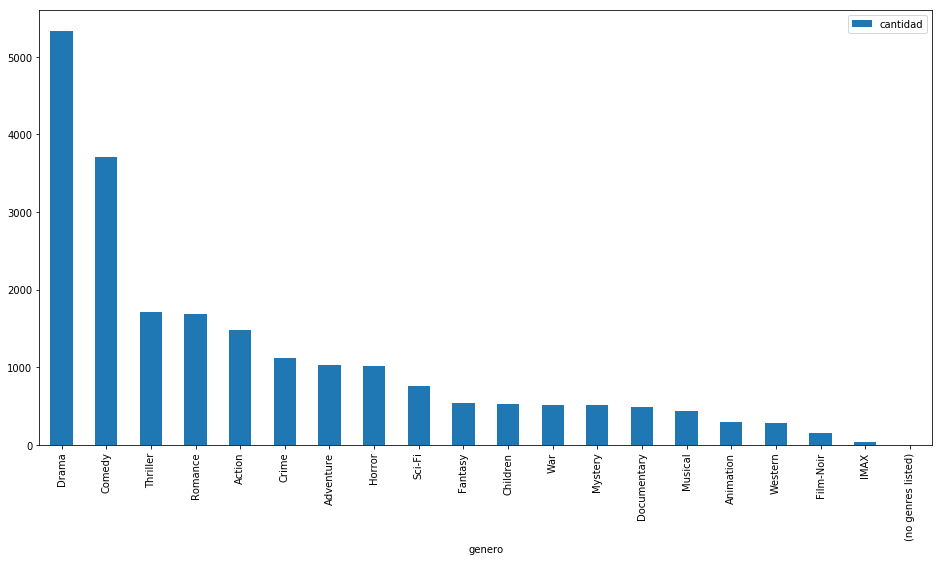

In [8]:
generos.plot(kind='bar', figsize=(16,8))

Podemos ver que los géneros mayoritarios son Drama y Comedia, que tiene más del dobel de la cantidad de cualquier otro género. Además hay una película a la que no se le asigno ningún genero, pero la frase que se uso puede introducir ruido al analisis.

In [9]:
movies[movies.genero.apply(lambda x: '(no genres listed)' in x)]

,id,titulo,genero
7903,8606,Pull My Daisy (1958),[(no genres listed)]


In [10]:
movies.loc[7903, 'genero'] = '[]'

In [11]:
movies.loc[7903]

id                        8606
titulo    Pull My Daisy (1958)
genero                      []
Name: 7903, dtype: object

A paritr de cada película y de los géneros que tiene esa película, vamos a construir un sistema de recomendación basado en contenido en donde el primer paso es vectorizar los generos, para luego comparar y calcular la similitud con esos vectores.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0)
tfidf_matrix = tf.fit_transform(movies.genero.str.join(' '))
tfidf_matrix.shape

(10681, 170)

Al utilizar el vectorizador ``TfidfVectorizer`` de ``sklearn.feature_extraction.text`` lo que se hizo fue para cada pélicula que tanto aporta relativamente que contanga un término. En donde término puede ser un género o 2 géneros juntos, al haber seleccionado `` ngram_range=(1, 2)``.

Con esto nos queda una matriz de 10681 filas (que se corresponde una a cada película) y 170 columnas, en donde se condensa la información del género, es decir, 10681 vectores de 170 dimensiones.

In [13]:
tf.get_feature_names()[:10]

['action',
 'action adventure',
 'action animation',
 'action children',
 'action comedy',
 'action crime',
 'action drama',
 'action fantasy',
 'action horror',
 'action mystery']

Para medir la similitud entre 2 vectores, lo que se podría interpretar que tan parecidas son 2 películas, vamos a utilizar la similitud del coseno, que mide el coseno del ángulo que se forma entre los 2 vectores. Mientras más cercano a 1 sea ese número, más parecida va a ser la dirección de estos vectores. Por como se construyeron los vectores de Tfidf, todos tienen norma 1, por lo que calcular el coseno es lo mismo que calcular el producto punto.

In [14]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:5, :5]

array([[1.        , 0.31531565, 0.05845377, 0.05154964, 0.15606579],
       [0.31531565, 1.        , 0.        , 0.        , 0.        ],
       [0.05845377, 0.        , 1.        , 0.360078  , 0.3745457 ],
       [0.05154964, 0.        , 0.360078  , 1.        , 0.33030709],
       [0.15606579, 0.        , 0.3745457 , 0.33030709, 1.        ]])

En esa matriz simétrica está condensada toda la información de similitud, el valor que está en la posición (i,j) tiene el valor de similitud entre la película i y la película j. Es por eso que en la diagonal está simepre el 1.

Para encontrar las películas más parecidas a una en particular sólo habría que ordenar la columna (o fila) que corresponde a esa pel

In [15]:
def recomendacion(titulo):
    pelicula = movies[movies.titulo == titulo]
    orden = np.argsort(cosine_sim[pelicula.index.tolist()[0]])[::-1]
    return movies.loc[orden]

In [16]:
recomendacion('Ant Bully, The (2006)')[:10]

,id,titulo,genero
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
9895,53121,Shrek the Third (2007),"[Adventure, Animation, Children, Comedy, Fantasy]"
8577,26662,Kiki's Delivery Service (Majo no takkyûbin) (1...,"[Adventure, Animation, Children, Comedy, Fantasy]"
3665,3754,"Adventures of Rocky and Bullwinkle, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]"
9500,45074,"Wild, The (2006)","[Adventure, Animation, Children, Comedy, Fantasy]"
3924,4016,"Emperor's New Groove, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]"
9584,47124,"Ant Bully, The (2006)","[Adventure, Animation, Children, Comedy, Fantasy]"
3029,3114,Toy Story 2 (1999),"[Adventure, Animation, Children, Comedy, Fantasy]"
2210,2294,Antz (1998),"[Adventure, Animation, Children, Comedy, Fantasy]"
9838,51939,TMNT (Teenage Mutant Ninja Turtles) (2007),"[Action, Adventure, Animation, Children, Comed..."


In [17]:
recomendacion('Curious Case of Benjamin Button, The (2008)')[:10]

,id,titulo,genero
4080,4172,Simon Magus (1999),"[Drama, Fantasy, Mystery, Romance]"
2232,2316,Practical Magic (1998),"[Drama, Fantasy, Mystery, Romance]"
8307,9011,Portrait of Jennie (1948),"[Drama, Fantasy, Mystery, Romance]"
3829,3920,"Faraway, So Close (In weiter Ferne, so nah!) (...","[Drama, Fantasy, Mystery, Romance]"
10660,64957,"Curious Case of Benjamin Button, The (2008)","[Drama, Fantasy, Mystery, Romance]"
9604,47610,"Illusionist, The (2006)","[Drama, Fantasy, Mystery, Romance, Thriller]"
1984,2068,Fanny and Alexander (Fanny och Alexander) (1982),"[Drama, Fantasy, Mystery]"
9536,45730,Lady in the Water (2006),"[Drama, Fantasy, Mystery]"
10614,64275,"Blue Light, The (Das Blaue Licht) (1932)","[Drama, Fantasy, Mystery]"
9258,37955,Innocence (2004),"[Drama, Fantasy, Mystery]"


In [18]:
recomendacion('Holy Mountain, The (Montaña sagrada, La) (1973)')[:10]

,id,titulo,genero
8507,26326,"Holy Mountain, The (Montaña sagrada, La) (1973)","[Adventure, Comedy, Drama, Fantasy, Mystery, S..."
7009,7123,Naked Lunch (1991),"[Drama, Fantasy, Mystery, Sci-Fi]"
4780,4874,K-PAX (2001),"[Drama, Fantasy, Mystery, Sci-Fi]"
28,29,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]"
8677,27537,Nothing (2003),"[Comedy, Fantasy, Mystery, Sci-Fi]"
7917,8620,"Exterminating Angel, The (El Ángel exterminado...","[Comedy, Drama, Fantasy, Mystery]"
10516,62764,Black Moon (1975),"[Fantasy, Mystery, Sci-Fi, War]"
9536,45730,Lady in the Water (2006),"[Drama, Fantasy, Mystery]"
10614,64275,"Blue Light, The (Das Blaue Licht) (1932)","[Drama, Fantasy, Mystery]"
9258,37955,Innocence (2004),"[Drama, Fantasy, Mystery]"


In [19]:
recomendacion('Pull My Daisy (1958)')[:10]

,id,titulo,genero
10680,65133,Blackadder Back & Forth (1999),[Comedy]
3566,3655,Blow-Out (La Grande Bouffe) (1973),[Drama]
3564,3653,"Endless Summer, The (1966)",[Documentary]
3563,3652,City of the Living Dead (Paura nella città dei...,[Horror]
3562,3651,"Blood Spattered Bride, The (La Novia Ensangren...",[Horror]
3561,3650,Anguish (Angustia) (1987),[Horror]
3560,3649,American Gigolo (1980),[Drama]
3559,3648,"Abominable Snowman, The (1957)","[Horror, Sci-Fi]"
3558,3647,Running Free (1999),"[Adventure, Children, Drama]"
3557,3646,Big Momma's House (2000),[Comedy]
